![Logo](https://github.com/martinchristen/pyRT/blob/master/docs/img/pyRT_64.png?raw=true)


# Tutorial: An introduction to pyRT ("Pirate") using the Jupyter Notebook

### Last Update: December 27, 2016

FHNW - University of Applied Sciences and Arts Northwestern Switzerland
Martin Christen, martin.christen@fhnw.ch, @MartinChristen


PyRT (pronounced pirate) is a raytracer/image generator for Python 3.5. This project is mainly done with the following in mind:

* 2D Graphics in the Jupyter Notebook
* Ray Tracing in the Jupyter Notebook
* Teaching ray tracing
* Exploring ray tracing concepts for geo data using Python.
* Rendering geo data, including large point clouds.
* Implementing new algorithms for rendering large 3D city models.
* Creating 3D-Maps from OpenStreetMap data
* Server-side rendering / cloud based rendering


pyRT is in development. Everything is (pre-)alpha!

    pip install https://github.com/martinchristen/pyRT/archive/master.zip
    
pyRT **doesn't have any dependencies**, but it is recommended to install the following modules:

    pip install pillow --upgrade
    pip install numpy --upgrade
    pip install moviepy --upgrade
    pip install jupyter -–upgrade

Basically, it is up to you how to generate images, however if pillow isavailable, support for storing images is also available.

Source code is available on github:
https://github.com/martinchristen/pyRT

The project is also on Twitter: @PythonRayTracer

# Part 1: Using pyrt to Draw

## 1.1 Drawing Points

pyRT also contains some functionatly to create images using Standard functions to draw points, lines, circle, rectangles. This has nothing todo with ray tracing, but it is fun and an easy way to get started to "Image Generators". When using Jupyter notebook, images can be displayed directly using "RGBImage.display()"


In [1]:
from pyrt.renderer import RGBImage
from pyrt.math import Vec2, Vec3
import numpy as np
import random

In [2]:
w = 320
h = 240
image = RGBImage(w, h)

In [3]:
for i in range(5000):
    position = Vec2(random.randint(0, w - 1), random.randint(0, h - 1))
    color = Vec3(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
   
    image.drawPoint(position, color, 3)


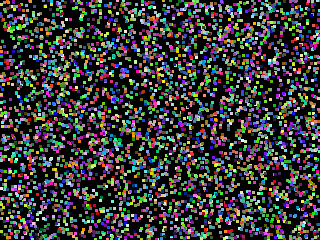

In [4]:
image.display()

### Saving Image to File

Saving to an image file can be done directly using "image.save(filename)". This requires PIL to be available.

In [5]:
image.save("rendering.png")

## 1.2 Drawing Lines

In [6]:
image = RGBImage(w, h)

In [7]:
for i in range(50):
    image.drawLine(Vec2(random.randint(0, w - 1), random.randint(0, h - 1)),
                   Vec2(random.randint(0, w - 1), random.randint(0, h - 1)),
                   Vec3(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)))


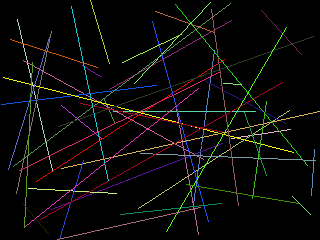

In [8]:
image.display()

## 1.3 Drawing Circles

A more elegant way to display images in Jupyter notebook is creating a base64 encoded PNG and display it using the HTML img tag. This can be done by storing the image using the BytesIO base64 modules.


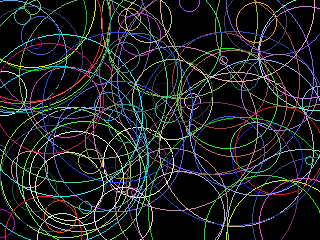

In [9]:
from pyrt.utils import display

image = RGBImage(w, h)
for i in range(100):
    image.drawCircle(Vec2(random.randint(0, w - 1), random.randint(0, h - 1)),
                     random.randint(3, 100),
                     Vec3(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)))
    
image.display()

## 1.4 Drawing Rectangles

As a last example on how to "draw" directly, we use the "drawRectangle" method to - surprise - draw some rectangles.


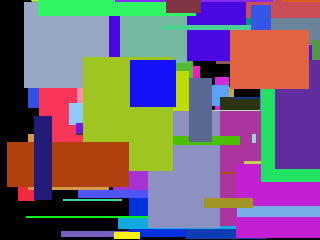

In [10]:
image = RGBImage(w, h)

for i in range(100):
    image.drawRectangle(Vec2(random.randint(0, w - 1), random.randint(0, h - 1)),
                        random.randint(1, w / 2), random.randint(1, h / 2),
                        Vec3(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)))
    
image.display()

## 1.5 Koch Snowflake

In [12]:
import math

def snowflake(image, lev, x1, y1, x5, y5, color):
    if lev == 0:
        image.drawLine(Vec2(x1, y1), Vec2(x5, y5), color)
    else:
        deltaX = x5 - x1
        deltaY = y5 - y1

        x2 = int(x1 + deltaX / 3.)
        y2 = int(y1 + deltaY / 3.)

        x3 = int(0.5 * (x1 + x5) + math.sqrt(3.) * (y1 - y5) / 6.)
        y3 = int(0.5 * (y1 + y5) + math.sqrt(3.) * (x5 - x1) / 6.)

        x4 = int(x1 + 2. * deltaX / 3.)
        y4 = int(y1 + 2. * deltaY / 3.)

        snowflake(image, lev - 1, x1, y1, x2, y2, color)
        snowflake(image, lev - 1, x2, y2, x3, y3, color)
        snowflake(image, lev - 1, x3, y3, x4, y4, color)
        snowflake(image, lev - 1, x4, y4, x5, y5, color)


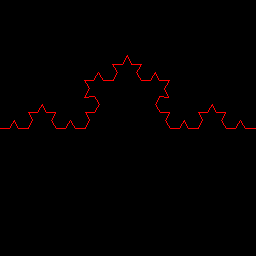

In [13]:
image = RGBImage(256, 256)
level = 3
snowflake(image, level, 0, 127, 255, 127, Vec3(1, 0, 0))
image.display()

# Part 2: An introduction to 3D Graphics

This part shows how we can draw in 3D. It introduces the submodules camera and geometry.

## 2.1 Drawing Perspective Triangles

In [14]:
from pyrt.renderer import RGBImage
from pyrt.math import Vec2, Vec3
from pyrt.camera import PerspectiveCamera
from pyrt.geometry import Triangle, Vertex

let's create a 320x240 image again:

In [15]:
w = 320
h = 240
image = RGBImage(w, h)

Now we create a camera: the image plane has the same size like out output image (320x240) and we define a field of view of 60 degrees.

In [16]:
camera = PerspectiveCamera(w,h,60)

This camera has its origin in (0,0,0) and points along the z-axis. This is not really what we want. So we can set where it is positioned and where it looks at.

    camera.setview(position, lookat, upvector)
   
position: camera position
lookat: where it looks at
upvector: for the orientation of the camera

In [17]:
camera.setView(Vec3(0,-10,0), Vec3(0,0,0), Vec3(0,0,1))

we can access the projection matrix and the view matrix using:

    camera.projection
    camera.view
    
These are 4x4 matrices.

In [18]:
print("Projection:")
print(camera.projection)
print("View:")
print(camera.view)

Projection:
[[1.2990381056766582, 0.0, 0.0, 0.0]
[0.0, 1.7320508075688776, 0.0, 0.0]
[0.0, 0.0, -1.0002000200020003, -0.20002000200020004]
[0.0, 0.0, -1.0, 0.0]]
View:
[[1.0, 0.0, -0.0, -0.0]
[0.0, 0.0, 1.0, -0.0]
[0.0, -1.0, 0.0, -10.0]
[0.0, 0.0, 0.0, 1.0]]


Thew view-projection matrix can be created by multiplying the two matrices. Please note that multiplications are done from right to left.

So we create the view-projection matrix using:

In [19]:
vp =  camera.projection * camera.view

print(vp)

[[1.2990381056766582, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.7320508075688776, 0.0]
[0.0, 1.0002000200020003, 0.0, 9.801980198019804]
[0.0, 1.0, 0.0, 10.0]]


Now we create a triangle. Triangles consists of 3 Vertices. A Vertex can have attributes like position, color, normal, ...). 

For this demo we only care about positions.

In [20]:
t = Triangle(Vertex(position=(-5, 1, 0)),
             Vertex(position=(0, 1, 5)),
             Vertex(position=(5, 1, 0)))

Now we multiply every vertex position of the triangle (t.a.position, t.b.position, t.c.position) with the view-projection matrix.

This results in normalized device coordinates (NDC) in the range (-1,-1,-1) to (1,1,1)

In [21]:
at = vp * t.a.position
bt = vp * t.b.position
ct = vp * t.c.position

The NDC are now transformed to image coordinates. The division by z is a perspective transformation.

In [22]:
a_screenpos = Vec2(int(w * 0.5*(at.x + 1.) / at.z), int(h * 0.5*(at.y + 1.)/ at.z))
b_screenpos = Vec2(int(w * 0.5*(bt.x + 1.) / bt.z), int(h * 0.5*(bt.y + 1.)/ at.z))
c_screenpos = Vec2(int(w * 0.5*(ct.x + 1.) / ct.z), int(h * 0.5*(ct.y + 1.)/ at.z))

And now we display the triangle by drawing the edges:


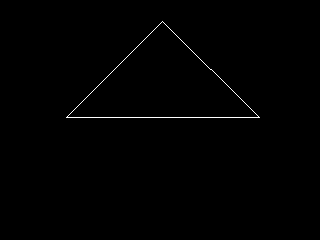

In [23]:
color = Vec3(1,1,1)
image.drawLine(a_screenpos, c_screenpos, color)
image.drawLine(c_screenpos, b_screenpos, color)
image.drawLine(b_screenpos, a_screenpos, color)

image.display()

# Part 3: Ray Tracing

With this knowledge we know how 3D graphics basically work. Now we use ray-tracing to create the same triangle as in the last example.

First we import the requires (sub-)modules

In [24]:
from pyrt.math import *
from pyrt.scene import *
from pyrt.geometry import Triangle, Vertex
from pyrt.camera import PerspectiveCamera
from pyrt.renderer import SimpleRT

Then we create our camera

In [25]:
w = 320
h = 240

camera = PerspectiveCamera(w, h, 60)
camera.setView(Vec3(0,-10,0), Vec3(0,0,0), Vec3(0,0,1))

The next step is to create a scene.
A scene consists of all objects you want to display. We just add a triangle to the scene.

In [26]:
scene = Scene()
scene.add(Triangle(Vertex(position=(-5, 1, 0)),
                   Vertex(position=(0, 1, 5)),
                   Vertex(position=(5, 1, 0))))

Now the scene has to know which camera we use for rendering, so we just set the camera:

In [27]:
scene.setCamera(camera)

Now we specify the raytracer. At the moment there is only one (reference) implementation of a raytracer, called **SimpleRT**

In [28]:
engine = SimpleRT()

# Creating Renderer: Simple Raytracer


Now we render the scene and display the result

# RENDER STATISTICS###############################
TIME FOR RENDERING: 2.6635491847991943s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 0
RAYS/s: 28833.708210944853
##################################################



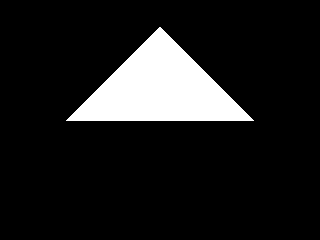

In [29]:
image = engine.render(scene)
image.display()

We create a new scene and this time we add some colors to the vertices:

In [30]:
scene = Scene()

scene.add(Triangle(Vertex(position=(-5, 1, 0), color=(1,0,0)),
                   Vertex(position=(0, 1, 5), color=(0,1,0)),
                   Vertex(position=(5, 1, 0), color=(0,0,1))))

scene.setCamera(camera)

and render again...

# RENDER STATISTICS###############################
TIME FOR RENDERING: 2.7003581523895264s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 0
RAYS/s: 28440.67181682558
##################################################



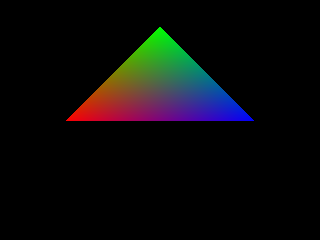

In [31]:
image = engine.render(scene)
image.display()

We can also create a scene with 2 triangles and render it:

# RENDER STATISTICS###############################
TIME FOR RENDERING: 3.8977391719818115s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 0
RAYS/s: 19703.729934538158
##################################################



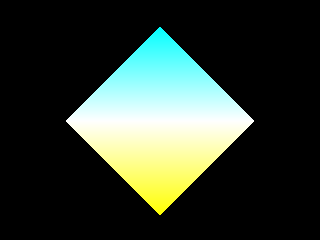

In [32]:
scene = Scene()

scene.add(Triangle(Vertex(position=(-5, 1, 0), color=(1,1,1)),
                   Vertex(position=(0, 1, 5), color=(0,1,1)),
                   Vertex(position=(5, 1, 0), color=(1,1,1))))

scene.add(Triangle(Vertex(position=(5, 1, 0), color=(1,1,1)),
                   Vertex(position=(0, 1, -5), color=(1,1,0)),
                   Vertex(position=(-5, 1, 0), color=(1,1,1))))

scene.setCamera(camera)

image = engine.render(scene)
image.display()

Instead of triangles we can also use spheres. Let's also look at materials. One material type is "PhongMaterial" where you can define the material of the object by specifying its color, its shinines, its reflectivity etc.

In [33]:
from pyrt.geometry import Sphere
from pyrt.material import PhongMaterial

In [34]:
scene = Scene()

scene.add(Sphere(center=Vec3(0.,0.,0.), radius=3., material=PhongMaterial(color=Vec3(1.,0.,0.))))

scene.setCamera(camera)

# RENDER STATISTICS###############################
TIME FOR RENDERING: 2.3740651607513428s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 0
RAYS/s: 32349.5754327545
##################################################



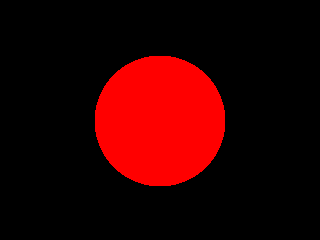

In [35]:
image = engine.render(scene)
image.display()

however, without light this object doesn't really look like a 3D-Object. So let's also add a point light. This light type is somewhat like a light bulb.

In [36]:
from pyrt.light import PointLight

# RENDER STATISTICS###############################
TIME FOR RENDERING: 2.761470079421997s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 0
RAYS/s: 27811.273630049614
##################################################



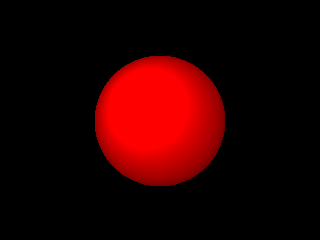

In [37]:
scene = Scene()

scene.addLight(PointLight(Vec3(-1,-8,1)))
scene.add(Sphere(center=Vec3(0.,0.,0.), radius=3., material=PhongMaterial(color=Vec3(1.,0.,0.))))

scene.setCamera(camera)

image = engine.render(scene)
image.display()

Now we're ready to create a larger scene. Let's create 4 spheres on top of a plane created using two triangles. Every piece should have a different material, so let's create materials first.

In [38]:
floormaterial = PhongMaterial(color=Vec3(0.5,0.5,0.5))
sphere0material = PhongMaterial(color=Vec3(1.,0.,0.), reflectivity=0.5)
sphere1material = PhongMaterial(color=Vec3(0.,1.,0.), reflectivity=0.5)
sphere2material = PhongMaterial(color=Vec3(0.,0.,1.), reflectivity=0.5)
sphere3material = PhongMaterial(color=Vec3(1.,1.,0.), reflectivity=0.5)

Lets create another view, from more above looking to (0,0,0)

In [39]:
camera = PerspectiveCamera(w, h, 45)
camera.setView(Vec3(0.,-10.,10.), Vec3(0.,0.,0.), Vec3(0.,0.,1.))

Now we create and add a light and geometries:

In [40]:
# Create a scene
scene = Scene()

# Add a light to the scene
scene.addLight(PointLight(Vec3(0,0,15)))


# Add "floor"
A = Vertex(position=(-5.0, -5.0, 0.0))
B = Vertex(position=( 5.0, -5.0, 0.0))
C = Vertex(position=( 5.0,  5.0, 0.0))
D = Vertex(position=(-5.0,  5.0, 0.0))

scene.add(Triangle(A,B,C, material=floormaterial))
scene.add(Triangle(A,C,D, material=floormaterial))

# Add 4 spheres
scene.add(Sphere(center=Vec3(-2.5,-2.5,1.75), radius=1.75, material=sphere0material))
scene.add(Sphere(center=Vec3( 2.5,-2.5,1.75), radius=1.75, material=sphere1material))
scene.add(Sphere(center=Vec3( 2.5, 2.5,1.75), radius=1.75, material=sphere2material))
scene.add(Sphere(center=Vec3(-2.5, 2.5,1.75), radius=1.75, material=sphere3material))

# Set the camera
scene.setCamera(camera)

now we are ready to render as usual:

# RENDER STATISTICS###############################
TIME FOR RENDERING: 8.985678911209106s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 0
RAYS/s: 8546.933488152632
##################################################



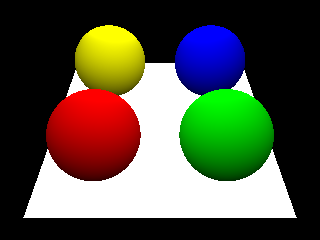

In [41]:
image = engine.render(scene)
image.display()

Now we tell the renderer to support shadows:

# Creating Renderer: Simple Raytracer
# Shadow Enabled
# RENDER STATISTICS###############################
TIME FOR RENDERING: 11.467482089996338s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 55280
RAYS/s: 11517.785592638513
##################################################



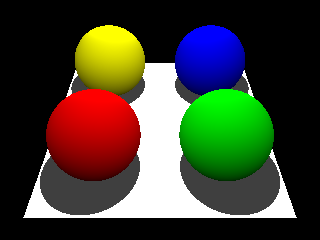

In [43]:
engine = SimpleRT(shadow=True)
image = engine.render(scene)
image.display()

And we can enable multiple iterations for rays. So a ray doesn't stop at an object if the material is reflecting.

# Creating Renderer: Simple Raytracer
# Shadow Enabled
# Iterations: 3
# RENDER STATISTICS###############################
TIME FOR RENDERING: 14.199985980987549s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 26456
NUMBER OF SHADOW RAYS: 62923
RAYS/s: 11702.758032472575
##################################################



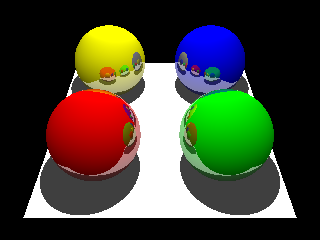

In [44]:
engine = SimpleRT(shadow=True, iterations=3)
image = engine.render(scene)
image.display()

# Outlook

Master Thesis Markus Fehr adds GPU support. Speeds of ca. 89'000'000 rays/sec with a NVIDIA 1080 GPU. His MTh will finish in January 2017.

Markus Fehr, "Beleuchtungsmodelle für 3D Stadtmodelle für GPU optimiertes Rendering in der Cloud", Master Thesis 2017

<img src="img/Berlin_AO.PNG">
